In [1]:
# All required python standard libraries
import os
import time

In [2]:
# All torch related imports 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torch import nn, optim
import torchvision

In [3]:
# using cv2 to read an image
import cv2

In [4]:
# All sci-kit related imports 
import pandas as pd
import numpy as np

In [5]:
from tqdm.notebook import tqdm as tq

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
IMAGE_DIMS = 24

In [8]:
def accuracy_finder(predictions , labels):
    values, max_indices = torch.max(predictions, dim=1)
    accuracy = ( max_indices == labels ).sum()
    return accuracy/max_indices.size()[0]

In [9]:
def csv_preprocessor(base_dir:str, directory:str):
    return os.path.join(base_dir,directory).replace("\\","/")

In [10]:
def return_all_image_list_from_processed_csv(csv_file):
    ### This returns the entire list full of images to be loaded into cpu
    ###
    ###
    ALL_IMAGES = []
    start = time.time()
    for i, items in tq(enumerate(csv_file)):
        image = cv2.imread(items, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(image,(IMAGE_DIMS,IMAGE_DIMS))
        ALL_IMAGES.append(resized)
    
    print("Tt took us approximately {} seconds".format(time.time()-start))  
    return ALL_IMAGES

In [11]:
def get_one_hot_encoded_labels(input_data_frame):
    input_data_frame.labels = input_data_frame.labels.map(lambda x: x-1)
    # return pd.get_dummies(input_data_frame.labels, prefix='labels').to_numpy()
    return input_data_frame.labels

In [12]:
# pytorch device configurations 
BATCH_SIZE = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
DEVICE

device(type='cuda')

In [14]:
train_csv_directory = os.path.join(os.getcwd(),'guides\\isolated-dataset-csv\\IsolatedTrain.csv')

In [15]:
DATASET_DATAFRAME = pd.read_csv(train_csv_directory, usecols=["labels","directory"])
DATASET_DATAFRAME.labels = DATASET_DATAFRAME.labels - 1
DATASET_DATAFRAME

,labels,directory
0,0,dataset\IsolatedTrain\1\bcc000000.bmp
1,0,dataset\IsolatedTrain\1\bcc000133.bmp
2,0,dataset\IsolatedTrain\1\bcc000134.bmp
3,0,dataset\IsolatedTrain\1\bcc000135.bmp
4,0,dataset\IsolatedTrain\1\bcc000136.bmp
...,...,...
34434,170,dataset\IsolatedTrain\171\bcc000067.bmp
34435,170,dataset\IsolatedTrain\171\bcc000068.bmp
34436,170,dataset\IsolatedTrain\171\bcc000069.bmp
34437,170,dataset\IsolatedTrain\171\bcc000071.bmp


In [16]:
X_TRAIN_CSV, X_VAL_CSV,Y_TRAIN, Y_VAL = train_test_split(DATASET_DATAFRAME.directory, DATASET_DATAFRAME.labels, test_size=0.15, stratify=DATASET_DATAFRAME.labels)

In [17]:
print(len(X_TRAIN_CSV),len(X_VAL_CSV),len(Y_TRAIN), len(Y_VAL))

29273 5166 29273 5166


In [18]:
DATA_NORMALIZER = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),transforms.Resize((IMAGE_DIMS,IMAGE_DIMS))])

In [19]:
class LeanIsolatedCharacterDataset(Dataset):
    def __init__(self, image_dirs_data_frame, labels,  transforms=None):
          
        ### labels
        self.labels = labels.to_numpy()
        
        ### loading dataset into memory
        self.dataset_csv = image_dirs_data_frame.map(lambda x: csv_preprocessor(base_dir=str(os.getcwd()), directory=str(x)))
        self.ALL_IMAGES = return_all_image_list_from_processed_csv(csv_file=self.dataset_csv)
        
        ### transformations to apply on images
        self.transforms = transforms
        
    def __getitem__(self, index):
        # convert labels to tensor 
        label = torch.tensor(self.labels[index])
        # load single image from list of all preloaded images
        image = self.ALL_IMAGES[index]
        if self.transforms:
            ## apply transforms 
            image = self.transforms(image)    
            image = image.float()
        label = label.long()
        return image, label 
    
    def __len__(self):
        return len(self.ALL_IMAGES)

In [20]:
TRAINING_DATASET = LeanIsolatedCharacterDataset(image_dirs_data_frame=X_TRAIN_CSV, labels=Y_TRAIN, transforms=DATA_NORMALIZER)


Tt took us approximately 4.1631152629852295 seconds


In [21]:
len(TRAINING_DATASET)

29273

In [22]:
VALIDATION_DATASET = LeanIsolatedCharacterDataset(image_dirs_data_frame=X_VAL_CSV, labels=Y_VAL, transforms=DATA_NORMALIZER)


Tt took us approximately 0.7453083992004395 seconds


In [23]:
len(VALIDATION_DATASET)

5166

In [24]:
TRAINING_LOADER = DataLoader(dataset=TRAINING_DATASET,batch_size=BATCH_SIZE,shuffle=True)
VALIDATION_LOADER = DataLoader(dataset=VALIDATION_DATASET,batch_size=BATCH_SIZE,shuffle=True)

In [25]:
class block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1,)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding=0,)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
    
    #Identity block
    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        #x = self.relu(x) #custom 

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [26]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels change
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * 4, kernel_size=1, stride=stride,),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [27]:
def ResNet50(img_channel=3, num_classes=171):
    return ResNet(block, [2, 3, 5, 2], img_channel, num_classes)
net = ResNet50()

In [28]:
optimizer =  optim.Adam(net.parameters(), lr=0.07) # learning rate 
# defining the loss function
criterion =  nn.CrossEntropyLoss() # reduction='none'
net = net.to(DEVICE)
criterion = criterion.to(DEVICE)

In [29]:
from tqdm import tqdm 

In [30]:
def validate(ValidationLoader):
    total_val_accuracy = 0
    total_val_loss = 0 
    
    for i, data in enumerate(ValidationLoader, 0):
       # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_val_loss += loss
        val_accuracy = accuracy_finder(predictions=outputs, labels=labels)
        total_val_accuracy = total_val_accuracy + val_accuracy
        
    return (total_val_loss/len(ValidationLoader), total_val_accuracy/len(ValidationLoader))

In [31]:
def training(epochs:int = 0, TRAINING_LOADER = TRAINING_LOADER , VALIDATION_LOADER = VALIDATION_LOADER, OPTIM_MODEL_NAME="" ):
    all_training_losses = []
    all_training_accuracy = []
    
    all_validation_losses = []
    all_validation_accuracy = []
    
    minimum_validation_loss = torch.tensor(999999999).to(DEVICE)
    minimum_validation_epoch_number = -1
    
    
    for epoch in tq(range(epochs)):
        total_epoch_loss = 0
        total_accuracy_epoch = 0
        for i, data in tqdm(enumerate(TRAINING_LOADER, 0)): 
            image,label = data
            
            optimizer.zero_grad(set_to_none=True)
            
            label = label.to(DEVICE)
            image = image.to(DEVICE)
            output = net(image)
            
            
            
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                total_epoch_loss += loss
                batches_training_accuracy = accuracy_finder(predictions=output, labels=label)
                total_accuracy_epoch = total_accuracy_epoch  + batches_training_accuracy   
            
            if i % 100 == 0 and i != 0: 
                print("Batch : {}/{}".format(i, len(TRAINING_LOADER)))
           
        # total epoch loss 
        total_epoch_loss = total_epoch_loss / len(TRAINING_LOADER)
        # total epoch accuracy 
        total_accuracy_epoch = total_accuracy_epoch /len(TRAINING_LOADER)
        
        optimizer.zero_grad(set_to_none=True)
        with torch.no_grad():
             validation_loss, validation_accuracy = validate(ValidationLoader= VALIDATION_LOADER )
        
        all_validation_losses.append(validation_loss)
        all_validation_accuracy.append(validation_accuracy)
        
        if minimum_validation_loss > validation_loss:
            validation_loss = minimum_validation_loss
            minimum_validation_epoch_number = epoch
            print("Saved model at epoch {}".format(epoch+1))
            PATH = OPTIM_MODEL_NAME
            # saving model
            torch.save(net.state_dict(), PATH)
            
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}, acc = {:.8f}, val_loss = {:.8f} , val_acc = {:.8f}".format(epoch + 1, epochs, total_epoch_loss, total_accuracy_epoch, validation_loss, validation_accuracy ))
        all_training_losses.append(total_epoch_loss)
        all_training_accuracy.append(total_accuracy_epoch)
        
    print("Training completed")
    return all_training_accuracy, all_training_losses,all_validation_accuracy,all_validation_losses,minimum_validation_epoch_number, minimum_validation_loss

In [32]:
PATH = "./models"
MODEL_NAME = "custom_resnet_50"
MODEL_NAME_PATH = "{}/{}_minimum_validation_loss.pth".format(PATH,MODEL_NAME)
OPTIM_MODEL_NAME_PATH = "{}/{}_minimum_validation_loss.pth".format(PATH,MODEL_NAME)

In [33]:
t_acc, t_loss, v_acc, v_loss, min_val_loss, min_val_loss_epoch = training(100, TRAINING_LOADER = TRAINING_LOADER , VALIDATION_LOADER = VALIDATION_LOADER, OPTIM_MODEL_NAME=OPTIM_MODEL_NAME_PATH)

101it [01:10,  1.44it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 1/100, loss = 9.02467155, acc = 0.00889946, val_loss = 5.07501936 , val_acc = 0.01107984


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 2/100, loss = 4.97059870, acc = 0.01375259, val_loss = 4.85180521 , val_acc = 0.01339286


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:19,  1.46it/s]
0it [00:00, ?it/s]

epoch : 3/100, loss = 4.79518843, acc = 0.01944232, val_loss = 4.70735788 , val_acc = 0.02635708


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 4/100, loss = 4.65159273, acc = 0.02729299, val_loss = 4.51416731 , val_acc = 0.02986704


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 5/100, loss = 4.46786261, acc = 0.03689317, val_loss = 4.39655590 , val_acc = 0.04041311


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 6/100, loss = 4.30878925, acc = 0.04510450, val_loss = 4.18292904 , val_acc = 0.04886452


101it [01:10,  1.45it/s]

Batch : 100/115


115it [01:20,  1.42it/s]
0it [00:00, ?it/s]

epoch : 7/100, loss = 4.19124937, acc = 0.05315934, val_loss = 4.08892059 , val_acc = 0.05450149


101it [01:09,  1.42it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 8/100, loss = 4.04704666, acc = 0.06348963, val_loss = 3.96723938 , val_acc = 0.07083818


101it [01:09,  1.41it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 9/100, loss = 3.91709900, acc = 0.07337414, val_loss = 3.89208913 , val_acc = 0.07639428


101it [01:10,  1.40it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 10/100, loss = 3.79003167, acc = 0.08502916, val_loss = 3.79913998 , val_acc = 0.09196267


101it [01:10,  1.44it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 11/100, loss = 3.68949294, acc = 0.09379733, val_loss = 3.71456695 , val_acc = 0.09594980


101it [01:12,  1.39it/s]

Batch : 100/115


115it [01:22,  1.40it/s]
0it [00:00, ?it/s]

epoch : 12/100, loss = 3.56715250, acc = 0.10834376, val_loss = 3.52949357 , val_acc = 0.11476126


101it [01:11,  1.42it/s]

Batch : 100/115


115it [01:21,  1.41it/s]
0it [00:00, ?it/s]

epoch : 13/100, loss = 3.42267752, acc = 0.12300928, val_loss = 3.50296235 , val_acc = 0.12068938


101it [01:11,  1.43it/s]

Batch : 100/115


115it [01:21,  1.42it/s]
0it [00:00, ?it/s]

epoch : 14/100, loss = 3.34253979, acc = 0.13455819, val_loss = 3.35684061 , val_acc = 0.13994566


101it [01:12,  1.39it/s]

Batch : 100/115


115it [01:22,  1.40it/s]
0it [00:00, ?it/s]

epoch : 15/100, loss = 3.21246481, acc = 0.15334636, val_loss = 3.31691527 , val_acc = 0.15119533


101it [01:13,  1.34it/s]

Batch : 100/115


115it [01:24,  1.36it/s]
0it [00:00, ?it/s]

epoch : 16/100, loss = 3.13693261, acc = 0.16247098, val_loss = 3.23410630 , val_acc = 0.15502070


101it [01:15,  1.31it/s]

Batch : 100/115


115it [01:26,  1.34it/s]
0it [00:00, ?it/s]

epoch : 17/100, loss = 3.02242374, acc = 0.18463872, val_loss = 3.23176980 , val_acc = 0.16991784


101it [01:14,  1.31it/s]

Batch : 100/115


115it [01:24,  1.36it/s]
0it [00:00, ?it/s]

epoch : 18/100, loss = 2.94254208, acc = 0.19507548, val_loss = 3.08504629 , val_acc = 0.18581781


101it [01:14,  1.37it/s]

Batch : 100/115


115it [01:24,  1.36it/s]
0it [00:00, ?it/s]

epoch : 19/100, loss = 2.84612012, acc = 0.21004671, val_loss = 3.03800797 , val_acc = 0.18980493


101it [01:13,  1.37it/s]

Batch : 100/115


115it [01:23,  1.37it/s]
0it [00:00, ?it/s]

epoch : 20/100, loss = 2.75911450, acc = 0.22568467, val_loss = 2.97403169 , val_acc = 0.21918672


101it [01:13,  1.39it/s]

Batch : 100/115


115it [01:23,  1.38it/s]
0it [00:00, ?it/s]

epoch : 21/100, loss = 2.67998433, acc = 0.24357252, val_loss = 3.05271888 , val_acc = 0.21002361


101it [01:13,  1.30it/s]

Batch : 100/115


115it [01:24,  1.37it/s]
0it [00:00, ?it/s]

epoch : 22/100, loss = 2.68697095, acc = 0.24530067, val_loss = 2.99326992 , val_acc = 0.23726223


101it [01:13,  1.37it/s]

Batch : 100/115


115it [01:23,  1.38it/s]
0it [00:00, ?it/s]

epoch : 23/100, loss = 2.53796196, acc = 0.27749372, val_loss = 2.91275167 , val_acc = 0.24632020


101it [01:13,  1.38it/s]

Batch : 100/115


115it [01:23,  1.38it/s]
0it [00:00, ?it/s]

epoch : 24/100, loss = 2.47831011, acc = 0.29054138, val_loss = 2.93125415 , val_acc = 0.25553992


101it [01:14,  1.36it/s]

Batch : 100/115


115it [01:24,  1.36it/s]
0it [00:00, ?it/s]

epoch : 25/100, loss = 2.43554020, acc = 0.29572964, val_loss = 2.83047915 , val_acc = 0.25761032


101it [01:12,  1.34it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 26/100, loss = 2.34410262, acc = 0.32310772, val_loss = 2.84290218 , val_acc = 0.27066350


101it [01:13,  1.39it/s]

Batch : 100/115


115it [01:23,  1.38it/s]
0it [00:00, ?it/s]

epoch : 27/100, loss = 2.45028067, acc = 0.29699978, val_loss = 2.80984640 , val_acc = 0.29160199


101it [01:13,  1.37it/s]

Batch : 100/115


115it [01:23,  1.37it/s]
0it [00:00, ?it/s]

epoch : 28/100, loss = 2.21229243, acc = 0.35239184, val_loss = 2.84198976 , val_acc = 0.28891695


101it [01:13,  1.39it/s]

Batch : 100/115


115it [01:23,  1.38it/s]
0it [00:00, ?it/s]

epoch : 29/100, loss = 2.12032032, acc = 0.37579995, val_loss = 2.61892509 , val_acc = 0.33812922


101it [01:14,  1.38it/s]

Batch : 100/115


115it [01:24,  1.37it/s]
0it [00:00, ?it/s]

epoch : 30/100, loss = 1.95626891, acc = 0.42211428, val_loss = 2.44858146 , val_acc = 0.38946852


101it [01:12,  1.36it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 31/100, loss = 1.87621462, acc = 0.45242235, val_loss = 2.27554345 , val_acc = 0.43227550


101it [01:12,  1.39it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 32/100, loss = 1.72415090, acc = 0.48766294, val_loss = 2.39445567 , val_acc = 0.40376714


101it [01:13,  1.34it/s]

Batch : 100/115


115it [01:23,  1.37it/s]
0it [00:00, ?it/s]

epoch : 33/100, loss = 1.75381792, acc = 0.48444903, val_loss = 2.27286744 , val_acc = 0.44324213


101it [01:13,  1.33it/s]

Batch : 100/115


115it [01:23,  1.37it/s]
0it [00:00, ?it/s]

epoch : 34/100, loss = 1.56868279, acc = 0.53788012, val_loss = 2.32740355 , val_acc = 0.44964743


101it [01:12,  1.40it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 35/100, loss = 1.70607877, acc = 0.50912195, val_loss = 2.23655915 , val_acc = 0.48610574


101it [01:13,  1.32it/s]

Batch : 100/115


115it [01:23,  1.37it/s]
0it [00:00, ?it/s]

epoch : 36/100, loss = 1.43446255, acc = 0.57542670, val_loss = 2.18008637 , val_acc = 0.48777986


101it [01:12,  1.38it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 37/100, loss = 1.37983429, acc = 0.59214699, val_loss = 2.13598466 , val_acc = 0.50236964


101it [01:12,  1.39it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 38/100, loss = 1.32465315, acc = 0.60989517, val_loss = 2.17017770 , val_acc = 0.51238191


101it [01:12,  1.40it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 39/100, loss = 1.26990199, acc = 0.62930316, val_loss = 2.16585040 , val_acc = 0.52147228


101it [01:13,  1.33it/s]

Batch : 100/115


115it [01:23,  1.37it/s]
0it [00:00, ?it/s]

epoch : 40/100, loss = 1.28108990, acc = 0.62532133, val_loss = 2.09315062 , val_acc = 0.53635323


101it [01:12,  1.41it/s]

Batch : 100/115


115it [01:22,  1.39it/s]
0it [00:00, ?it/s]

epoch : 41/100, loss = 1.12686014, acc = 0.66679972, val_loss = 2.19644403 , val_acc = 0.54937404


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 42/100, loss = 1.14607060, acc = 0.66747832, val_loss = 2.22057748 , val_acc = 0.54682648


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 43/100, loss = 1.28872406, acc = 0.63627559, val_loss = 2.11343718 , val_acc = 0.54021090


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 44/100, loss = 1.07867515, acc = 0.68569815, val_loss = 2.13109136 , val_acc = 0.57214838


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 45/100, loss = 1.02654207, acc = 0.69870770, val_loss = 2.10717797 , val_acc = 0.59002978


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 46/100, loss = 1.00793409, acc = 0.71029055, val_loss = 2.11404991 , val_acc = 0.59359634


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 47/100, loss = 0.96272784, acc = 0.72944814, val_loss = 2.10269308 , val_acc = 0.59071720


101it [01:08,  1.46it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 48/100, loss = 0.87544477, acc = 0.74848711, val_loss = 2.15929580 , val_acc = 0.59821427


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 49/100, loss = 0.85631150, acc = 0.75388372, val_loss = 2.05470490 , val_acc = 0.62635875


101it [01:08,  1.46it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 50/100, loss = 0.84285569, acc = 0.76127601, val_loss = 2.43793392 , val_acc = 0.59635419


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 51/100, loss = 0.85825282, acc = 0.75603241, val_loss = 2.24771547 , val_acc = 0.62103713


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 52/100, loss = 0.81100321, acc = 0.77428931, val_loss = 2.11539197 , val_acc = 0.61445397


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 53/100, loss = 0.82599491, acc = 0.76920718, val_loss = 2.18696189 , val_acc = 0.62661749


101it [01:09,  1.41it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 54/100, loss = 0.83739328, acc = 0.77101165, val_loss = 2.27100134 , val_acc = 0.63070977


101it [01:10,  1.44it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 55/100, loss = 0.86483794, acc = 0.76769584, val_loss = 2.06097174 , val_acc = 0.65895122


101it [01:10,  1.44it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 56/100, loss = 0.65154278, acc = 0.81419754, val_loss = 2.05665588 , val_acc = 0.66905248


101it [01:10,  1.45it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 57/100, loss = 0.66257167, acc = 0.81910074, val_loss = 2.18638897 , val_acc = 0.63692904


101it [01:10,  1.44it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 58/100, loss = 0.81707817, acc = 0.78465396, val_loss = 2.16693759 , val_acc = 0.63663787


101it [01:10,  1.40it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 59/100, loss = 0.69587076, acc = 0.80499202, val_loss = 2.05075884 , val_acc = 0.67922652


101it [01:10,  1.45it/s]

Batch : 100/115


115it [01:20,  1.44it/s]
0it [00:00, ?it/s]

epoch : 60/100, loss = 0.54333609, acc = 0.84691280, val_loss = 2.06945682 , val_acc = 0.67527175


101it [01:10,  1.43it/s]

Batch : 100/115


115it [01:20,  1.44it/s]
0it [00:00, ?it/s]

epoch : 61/100, loss = 0.55769479, acc = 0.84113365, val_loss = 2.30282021 , val_acc = 0.66183037


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 62/100, loss = 0.55014706, acc = 0.84779513, val_loss = 2.26782990 , val_acc = 0.66249353


101it [01:09,  1.44it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 63/100, loss = 1.06016016, acc = 0.74545068, val_loss = 2.20869279 , val_acc = 0.58749843


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 64/100, loss = 0.65109724, acc = 0.81762409, val_loss = 2.06806540 , val_acc = 0.68260705


101it [01:09,  1.43it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 65/100, loss = 0.47965688, acc = 0.86867285, val_loss = 2.00791287 , val_acc = 0.69958270


101it [01:10,  1.40it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 66/100, loss = 0.48190525, acc = 0.86906785, val_loss = 2.19957709 , val_acc = 0.67878169


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 67/100, loss = 0.48389819, acc = 0.87207794, val_loss = 2.24344754 , val_acc = 0.66618145


101it [01:09,  1.41it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 68/100, loss = 0.49217206, acc = 0.86655813, val_loss = 2.32751036 , val_acc = 0.67875743


101it [01:10,  1.42it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 69/100, loss = 0.55473286, acc = 0.85389668, val_loss = 2.20406580 , val_acc = 0.67935592


101it [01:11,  1.43it/s]

Batch : 100/115


115it [01:21,  1.41it/s]
0it [00:00, ?it/s]

epoch : 70/100, loss = 0.59675694, acc = 0.84286183, val_loss = 2.34970570 , val_acc = 0.67054057


101it [01:10,  1.45it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 71/100, loss = 0.52123082, acc = 0.86163706, val_loss = 2.23534727 , val_acc = 0.67625034


101it [01:10,  1.42it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 72/100, loss = 0.53578168, acc = 0.85673314, val_loss = 2.38148761 , val_acc = 0.67726129


101it [01:09,  1.42it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 73/100, loss = 0.50652564, acc = 0.86390483, val_loss = 2.23613191 , val_acc = 0.69836152


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 74/100, loss = 0.43940711, acc = 0.88393682, val_loss = 2.23153639 , val_acc = 0.68669933


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 75/100, loss = 0.39590606, acc = 0.89369005, val_loss = 2.36835051 , val_acc = 0.70221114


101it [01:10,  1.40it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 76/100, loss = 0.42982578, acc = 0.88536388, val_loss = 2.26219344 , val_acc = 0.70367497


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 77/100, loss = 0.44466585, acc = 0.88624239, val_loss = 2.55996180 , val_acc = 0.68783969


101it [01:09,  1.42it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 78/100, loss = 0.41241872, acc = 0.88755029, val_loss = 2.24806929 , val_acc = 0.70954645


101it [01:09,  1.41it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 79/100, loss = 0.30047277, acc = 0.91765845, val_loss = 2.84575891 , val_acc = 0.70165306


101it [01:10,  1.43it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
0it [00:00, ?it/s]

epoch : 80/100, loss = 0.38799205, acc = 0.89878100, val_loss = 2.26217866 , val_acc = 0.70932811


101it [01:09,  1.43it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 81/100, loss = 0.47695974, acc = 0.88053626, val_loss = 2.33897924 , val_acc = 0.69872546


101it [01:09,  1.43it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 82/100, loss = 0.45313191, acc = 0.88422954, val_loss = 2.15884662 , val_acc = 0.70014071


101it [01:09,  1.44it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 83/100, loss = 0.29472497, acc = 0.92315274, val_loss = 2.20809269 , val_acc = 0.71828902


101it [01:09,  1.43it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 84/100, loss = 0.51093143, acc = 0.87534308, val_loss = 2.35289049 , val_acc = 0.70973247


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 85/100, loss = 0.33620027, acc = 0.91071647, val_loss = 2.20601773 , val_acc = 0.73114812


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 86/100, loss = 0.30726489, acc = 0.92035866, val_loss = 2.52235413 , val_acc = 0.70025396


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 87/100, loss = 0.33248559, acc = 0.91479641, val_loss = 2.52240014 , val_acc = 0.70417637


101it [01:10,  1.46it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 88/100, loss = 0.43604335, acc = 0.88863724, val_loss = 2.37680483 , val_acc = 0.71081620


101it [01:10,  1.43it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 89/100, loss = 0.34305495, acc = 0.91009212, val_loss = 2.59783268 , val_acc = 0.70716065


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 90/100, loss = 0.33421931, acc = 0.91582376, val_loss = 2.43199062 , val_acc = 0.70839804


101it [01:09,  1.40it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 91/100, loss = 0.34354946, acc = 0.91088629, val_loss = 2.49773574 , val_acc = 0.71517539


101it [01:08,  1.45it/s]

Batch : 100/115


115it [01:18,  1.46it/s]
0it [00:00, ?it/s]

epoch : 92/100, loss = 0.24616034, acc = 0.93529594, val_loss = 2.62642503 , val_acc = 0.72718525


101it [01:09,  1.46it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 93/100, loss = 0.27420282, acc = 0.92893559, val_loss = 2.48982167 , val_acc = 0.71595174


101it [01:09,  1.44it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 94/100, loss = 0.29066011, acc = 0.92750859, val_loss = 2.76967549 , val_acc = 0.70184720


101it [01:09,  1.42it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 95/100, loss = 0.29130104, acc = 0.92390841, val_loss = 2.62225485 , val_acc = 0.71783614


101it [01:09,  1.44it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 96/100, loss = 0.19824316, acc = 0.94548148, val_loss = 2.75831056 , val_acc = 0.72860056


101it [01:10,  1.44it/s]

Batch : 100/115


115it [01:19,  1.44it/s]
0it [00:00, ?it/s]

epoch : 97/100, loss = 0.37432086, acc = 0.90945095, val_loss = 2.53006268 , val_acc = 0.71711630


101it [01:09,  1.43it/s]

Batch : 100/115


115it [01:19,  1.45it/s]
0it [00:00, ?it/s]

epoch : 98/100, loss = 0.30085990, acc = 0.92360687, val_loss = 2.58290029 , val_acc = 0.72997546


101it [01:10,  1.39it/s]

Batch : 100/115


115it [01:20,  1.43it/s]
1it [00:00,  9.37it/s]

epoch : 99/100, loss = 0.26088792, acc = 0.93539780, val_loss = 2.65399313 , val_acc = 0.70965159


101it [01:09,  1.45it/s]

Batch : 100/115


115it [01:19,  1.45it/s]


epoch : 100/100, loss = 0.32667533, acc = 0.91829121, val_loss = 2.49402523 , val_acc = 0.72405541

Training completed


In [34]:
# saving model
torch.save(net.state_dict(), MODEL_NAME_PATH)
print("model was successfully saved")

model was successfully saved


In [35]:
import matplotlib.pyplot as plt

In [40]:
def result_plot(t_value,v_value,title,ylabel):
    result = []
    result_v = []
    for item, item_v in zip(t_value, v_value):
        result.append(item.cpu())
        result_v.append(item_v.cpu())
    plt.plot(result,'b')
    plt.plot(result_v,'r')
    
    plt.title(title)
    plt.legend(["training","validation"])
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.show()

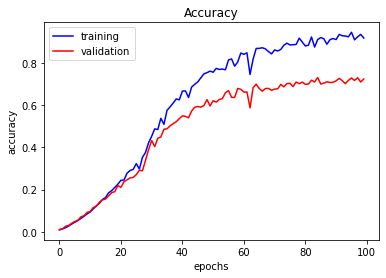

In [41]:
result_plot(t_value=t_acc,v_value=v_acc,title="Accuracy", ylabel="accuracy")

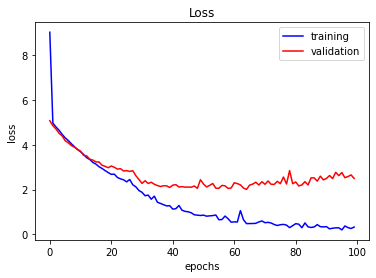

In [44]:
result_plot(t_value=t_loss,v_value=v_loss, title="Loss", ylabel="loss")